### Helpers

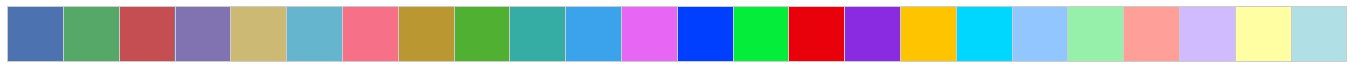

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
import utils
import scoring
from IPython.display import display

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [295]:
# train cols
train_cols = utils.TRAIN_COLUMNS #+ ['particle_type']

# original cols
x_cols = ['MatchedHit_X[%i]' % i for i in range(utils.N_STATIONS)]
y_cols = ['MatchedHit_Y[%i]' % i for i in range(utils.N_STATIONS)]
z_cols = ['MatchedHit_Z[%i]' % i for i in range(utils.N_STATIONS)]
xy_cols = x_cols + y_cols
xyz_cols = x_cols + y_cols + z_cols
dx_cols = ['MatchedHit_DX[%i]' % i for i in range(utils.N_STATIONS)]
dy_cols = ['MatchedHit_DY[%i]' % i for i in range(utils.N_STATIONS)]
dz_cols = ['MatchedHit_DZ[%i]' % i for i in range(utils.N_STATIONS)]
dxyz_cols = dx_cols + dy_cols + dz_cols

ex_cols = ['Lextra_X[%i]' % i for i in range(utils.N_STATIONS)]
ey_cols = ['Lextra_Y[%i]' % i for i in range(utils.N_STATIONS)]
exy_cols = ex_cols + ey_cols
edx_cols = ['Mextra_DX2[%i]' % i for i in range(utils.N_STATIONS)]
edy_cols = ['Mextra_DY2[%i]' % i for i in range(utils.N_STATIONS)]
edxy_cols = edx_cols + edy_cols

hit_type_cols = ['MatchedHit_TYPE[%i]' % i for i in range(utils.N_STATIONS)]
mom_cols = ['P', 'PT']
foi_stats_cols = ['FOI_hits_N', 'NShared']

# derivative cols
pca_x_cols = ['PCAMatchedHit_X[%i]' % i for i in range(utils.N_STATIONS)]
pca_y_cols = ['PCAMatchedHit_Y[%i]' % i for i in range(utils.N_STATIONS)]
pca_z_cols = ['PCAMatchedHit_Z[%i]' % i for i in range(utils.N_STATIONS)]
pca_xyz_cols = pca_x_cols + pca_y_cols + pca_z_cols

da_cols = ['MatchedHit_DA[%d]' % i for i in range(1, 4)]
is_muon_cols = ['IsMuonTight']
prob_hit_detector_cols = ['ProbHit[%i]' % i for i in range(utils.N_STATIONS)]
err_cols = ['ErrMSE', 'Chi2Quantile']

# cols to read except `id` and training columns
READ_COLS = xyz_cols + exy_cols + hit_type_cols + mom_cols + dxyz_cols + edxy_cols + foi_stats_cols
# x_cols + y_cols + z_cols + hit_type_cols + mom_cols + [
#     'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]', 'MatchedHit_DX[3]',
#     'MatchedHit_DY[0]', 'MatchedHit_DY[1]', 'MatchedHit_DY[2]', 'MatchedHit_DY[3]',
#     'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
#     'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]', 'MatchedHit_T[3]',
#     'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]', 'MatchedHit_DT[3]'
# ]

TRAINSET_COLS = READ_COLS + train_cols
TESTSET_COLS = READ_COLS

In [296]:
%%time
train_0 = pd.read_csv('data/train_part_1_v2.csv.gz', nrows=200000, na_values=['-9999.0', '255'], usecols=TRAINSET_COLS)
train_1 = pd.read_csv('data/train_part_2_v2.csv.gz', nrows=200000, na_values=['-9999.0', '255'], usecols=TRAINSET_COLS)
train = pd.concat([train_0, train_1], axis=0, ignore_index=True)

print(train.shape)

(400000, 50)
Wall time: 13.5 s


### Pipeline

In [297]:
def get_class(i):
    return train.index[train.label == i]

# Gets `n_rows` random samples from `data`
def get_samples(data, n_rows):
    indices = np.random.randint(len(data), size=n_rows)
    indices = np.sort(indices)
    return data.iloc[indices]

# Gets `n_rows` random samples from `data` with specified class proportions.
# If `prop_0` is None, it keeps `data`s natural proportions.
def get_samples_w_proptions(data, n_rows, prop_0=None):
    def get_class_samples(class_i, n_rows):
        class_indices = np.random.randint(len(class_i), size=n_rows)
        return class_i[class_indices]
    
    if prop_0 is None:
        prop_0 = len(class_0) / (len(class_0) + len(class_1))
    cnt_0 = int(n_rows * prop_0)
    class_0_indices = get_class_samples(class_0, cnt_0)
    class_1_indices = get_class_samples(class_1, n_rows - cnt_0)
    indices = np.concatenate((class_0_indices, class_1_indices))
    indices = np.sort(indices)
    return data.loc[indices, :]

# Gets `n_rows` head samples from `data` with specified class proportions.
# If `prop_0` is None, it keeps `data`s natural proportions.
# If `data` samples is not enough to fulfil proportions for any `class_i` then random sampling from the `class_i` is applied.
def get_head_w_proportions(data, n_rows, prop_0=None):
    def get_class_samples_head_smart(class_i, n_rows):
        cls_len = len(class_i)
        if cls_len > n_rows:
            return class_i[:n_rows]
        class_indices = np.concatenate((np.arange(cls_len),  np.random.randint(cls_len, size=n_rows-cls_len)))
        return class_i[class_indices]
    
    if prop_0 is None:
        prop_0 = len(class_0) / (len(class_0) + len(class_1))
    cnt_0 = int(n_rows * prop_0)
    class_0_indices = get_class_samples_head_smart(class_0, cnt_0)
    class_1_indices = get_class_samples_head_smart(class_1, n_rows - cnt_0)
    indices = np.concatenate((class_0_indices, class_1_indices))
    indices = np.sort(indices)
    return data.loc[indices, :]
    
print(np.count_nonzero(train.label == 0), np.count_nonzero(train.label == 1))

class_0 = get_class(0)
class_1 = get_class(1)

30588 369412


In [298]:
import xgboost as xgb
from sklearn import model_selection as mdsel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def fit(train):
    target_train = train[train_cols]
    
    # defined much later
    transformer = DataTransformer().fit(train)
    train = transformer.transform(train)
    
    estimator = xgb.XGBClassifier(n_estimators=60, n_jobs=3)
    estimator.fit(train.values, target_train.label.values, sample_weight=target_train.weight.values, eval_metric=scoring.rejection90_sklearn)
    return transformer, estimator
    
def predict(fitted_state, test):
    transformer, estimator = fitted_state
    
    test = transformer.transform(test)
    predictions = estimator.predict_proba(test.values)[:, 1]
    return predictions

def score(fitted_state, test):
    target_test = test.loc[:, train_cols]
    predictions = predict(fitted_state, test)
    return scoring.rejection90(target_test.label.values, predictions, sample_weight=target_test.weight.values)

def fit_predict_save(train, test, filename):
    fitted_state = fit(train)
    predictions = predict(fitted_state, test)
    
    pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
        filename, index_label=utils.ID_COLUMN
    )
    
def cross_validate(train, n_splits, n_rows):
    train = get_head_w_proportions(train, n_rows, .5)
    
    splitter = mdsel.StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = []
    for train_indices, test_indices in splitter.split(train, train.label):
        train_subset = train.iloc[train_indices, :]
        test_subset = train.iloc[test_indices, :]
        
        fit_state = fit(train_subset)
        
        target_test = test_subset[train_cols]
        predictions = predict(fit_state, test_subset)
        
        y_true = target_test.label.values
        l, r, ep = scoring.get_threshold_details(y_true, predictions, sample_weight=target_test.weight.values)
        threshold = (l + r) / 2
        y_pred = predictions >= threshold
                
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, predictions)
        scr = scoring.rejection90(y_true, predictions, sample_weight=target_test.weight.values)
        scores += [[acc, prec, rec, f1, roc_auc, scr, threshold, r - l]]

    return pd.DataFrame(scores, columns=['acc', 'prec', 'rec', 'f1', 'roc_auc', 'scr', 'th', 'dTh'])

### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

##### PCA

In [191]:
from sklearn.decomposition import PCA

def fill_na(data):
    mask = data.isna()
    means = data.mean(skipna=True)
    data.fillna(means, inplace=True)
    return mask

def restore_na(data, mask):
    data.mask(mask, other=np.NaN, inplace=True)
    
def get_nth_detector_coords(i):
    return [x_cols[i], y_cols[i], z_cols[i]]

def get_nth_detector_coords_pca(i):
    return [pca_x_cols[i], pca_y_cols[i], pca_z_cols[i]]
    
def pca_fit(data):
    cols = get_nth_detector_coords(0)
    data = data[cols].copy()
    
    fill_na(data)
    pca_model = PCA(n_components=3)
    pca_model.fit(data)
    return pca_model

def pca_transform(pca_model, data, features):
    for i in range(4):
        cols = get_nth_detector_coords(i)
        new_cols = get_nth_detector_coords_pca(i)
        data_detector = data.loc[:, cols]
        
        mask = fill_na(data_detector)
        transformed_data = pca_model.transform(data_detector.values)
        restore_na(data_detector, mask)
        return
        
        for j in range(3):
            data[new_cols[j]] = transformed_data[:, j]

    features += pca_coord_cols
    return data

##### Cosine dist

In [192]:
def add_coses(data, features):
    def get_layer_coords(data, i):
        return data[[x_cols[i], y_cols[i], z_cols[i]]].values

    def dot(x, y):
        return np.sum(x * y, axis=1)
    
    def norm(x):
        return np.sqrt(dot(x, x))

    def get_cosine_dist(L1, L2, L1_norm, L2_norm):
        return dot(L1, L2) / L1_norm / L2_norm
    
    def get_angle(cosines):
        return np.arccos(cosines, dtype=np.float32) / np.pi * 180
    
    layers = np.array([get_layer_coords(data, i) for i in range(4)])
    layers[1:] -= layers[:3]
    norms = list(map(norm, layers))
    
    for i in range(3):
        cosines = get_cosine_dist(layers[i], layers[i+1], norms[i], norms[i+1])
        angles = get_angle(cosines)
        data[da_cols[i]] = angles
        
    features += da_cols        
    return data

##### IsMuonTight

In [193]:
def add_is_muon_tight(data, features):
    def lt(p):
        return data.P < p
    def gt(p):
        return data.P >= p
    def M(i):
        return data[hit_type_cols[i]] == 2
    
    lt_6k_mask = lt(6000.) & M(0) & M(1)
    lt_10k_gt_6k_mask = gt(6000.) & lt(10000.) & M(0) & M(1) & (M(2) | M(3))
    gt_10k_mask = gt(10000.) & M(0) & M(1) & M(2) & M(3)
    
    data.loc[:, is_muon_cols[0]] = 1 * (lt_6k_mask | lt_10k_gt_6k_mask | gt_10k_mask)
    features += is_muon_cols        
    return data

##### Probability hit detector

In [194]:
def add_probability_hit_detector(data, features):
    p = data[mom_cols[0]].values
    
    def prob(i):
        alpha = (0.0260, 0.0021, 0.0015, 0.0008)
        beta = (2040., 2387., 3320., 3903.)
        t = (alpha[i] * (p - beta[i]))**(i+1)
        return t / (1 + t)
        
    for i in range(4):
        data.loc[:, prob_hit_detector_cols[i]] = prob(i)
        
    features += prob_hit_detector_cols
    return data

##### MSE

In [255]:
def add_mse(data, features):
    dx = data.loc[:, xy_cols].values - data.loc[:, exy_cols].values
    D = np.mean(dx**2, axis=1)
    
    data.loc[:, err_cols[0]] = D
    features += [err_cols[0]]
    return data


In [299]:
%%time
from sklearn.base import TransformerMixin

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
#         self.pca_model = pca_fit(data)
        return self

    def transform(self, data):
        data = data.copy()
        features = [] + xyz_cols + exy_cols + mom_cols + hit_type_cols + foi_stats_cols

#         pca_transform(self.pca_model, data, features)
#         add_is_muon_tight(data, features)
        add_coses(data, features)
        add_probability_hit_detector(data, features)
        add_mse(data, features)
        
        if features:
            data = data.loc[:, features]
        else:
            data = data.drop(train_cols, axis=1)
        return data

df_scores = cross_validate(train, n_splits=3, n_rows=100000)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.736900,0.683144,0.883740,0.770592,0.789221,0.679060,0.056185,0.0
std,0.002903,0.003873,0.003051,0.001394,0.001042,0.031455,0.003336,0.0
min,0.733785,0.678878,0.881915,0.769207,0.788033,0.649685,0.052447,0.0
25%,0.735585,0.681498,0.881979,0.769890,0.788842,0.662467,0.054848,0.0
50%,0.737385,0.684117,0.882042,0.770573,0.789651,0.675250,0.057249,0.0
75%,0.738457,0.685277,0.884652,0.771284,0.789815,0.693748,0.058054,0.0
max,0.739530,0.686438,0.887262,0.771994,0.789978,0.712247,0.058859,0.0


Wall time: 14.1 s


### Test theory

In [111]:
%%time
df_scores = cross_validate(train, n_splits=3, n_rows=100000)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.674110,0.623736,0.878700,0.729521,0.726821,0.423082,0.049594,0.0
std,0.012718,0.011744,0.003839,0.006837,0.008896,0.070076,0.003043,0.0
min,0.659426,0.610185,0.875322,0.721628,0.716717,0.344154,0.046125,0.0
25%,0.670326,0.620125,0.876612,0.727473,0.723494,0.395630,0.048484,0.0
50%,0.681226,0.630065,0.877902,0.733318,0.730270,0.447105,0.050843,0.0
75%,0.681451,0.630511,0.880389,0.733468,0.731873,0.462546,0.051328,0.0
max,0.681676,0.630958,0.882875,0.733617,0.733477,0.477988,0.051813,0.0


Wall time: 4.86 s


### Get result

In [202]:
test = pd.read_csv('data/test_public_v2.csv.gz', na_values=['-9999.0', '255'], usecols=TESTSET_COLS)

In [203]:
%%time
fit_predict_save(get_head_w_proportions(train, 100000, .5), test, "out/05_smse_mom_ht_x_ex_100.csv")

Wall time: 18.7 s


In [564]:
%%time
fit_predict_save(get_samples_w_proptions(train, 100000, .5), test, "out/04_prop_80_20_100_800.csv")

Wall time: 9.55 s


In [539]:
%%time
fit_predict_save(get_samples(train, 100000), test, "out/03_baseline_head_100.csv")

Wall time: 8.72 s


### Scratches

In [410]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [272]:
pd.DataFrame(np.sqrt(train.loc[:, edxy_cols].values)).describe()

,0,1,2,3,4,5,6,7
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,15.123538,25.901352,39.238078,55.169255,15.030142,25.741591,38.993102,54.819763
std,12.862626,22.401378,34.852459,50.424701,12.722432,22.161308,34.474598,49.870029
min,0.148230,0.250908,0.371559,0.509805,0.148265,0.250967,0.371646,0.509924
25%,5.959067,10.104724,15.036148,20.720360,5.954768,10.097390,15.027419,20.707803
50%,11.083974,18.813359,28.097191,38.916786,11.059929,18.770424,28.040232,38.839964
75%,20.310946,34.618125,52.090621,72.705470,20.195074,34.425842,51.802110,72.318682
max,168.789312,288.238616,419.332541,559.539185,167.239302,285.591141,415.480577,554.398972


In [274]:
train.loc[:, xy_cols + exy_cols].describe()

,MatchedHit_X[0],MatchedHit_X[1],MatchedHit_X[2],MatchedHit_X[3],MatchedHit_Y[0],MatchedHit_Y[1],MatchedHit_Y[2],MatchedHit_Y[3],Lextra_X[0],Lextra_X[1],Lextra_X[2],Lextra_X[3],Lextra_Y[0],Lextra_Y[1],Lextra_Y[2],Lextra_Y[3]
count,400000.000000,400000.000000,393411.000000,392917.000000,400000.000000,400000.000000,393411.000000,392917.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,1.729324,1.873392,1.729970,0.011901,-2.761385,-3.638012,-2.609367,-2.603435,1.506949,1.535690,1.564431,1.593172,-3.435250,-3.695902,-3.956554,-4.217206
std,1551.982853,1695.038391,1838.665829,1956.861588,1350.528976,1454.891844,1551.185870,1633.214372,1550.483588,1691.729681,1833.788478,1976.484750,1351.664989,1456.896577,1562.129454,1667.363373
min,-4829.580000,-5243.800000,-5534.870000,-5910.570000,-3951.223600,-4259.906700,-4567.468800,-4874.449700,-4831.491000,-5227.473600,-5634.651400,-6058.536600,-4047.200000,-4361.505000,-4675.809600,-4990.114300
25%,-815.455000,-893.350000,-966.870000,-1034.070000,-793.841700,-857.026370,-918.890100,-979.318850,-817.151600,-885.972865,-954.692825,-1024.241850,-787.092270,-848.760792,-910.477907,-972.269057
50%,-8.288333,8.068334,20.533333,-23.503334,-32.562122,-35.208393,-20.694553,-39.421116,-0.250149,-0.989890,-0.199358,0.144750,-16.382661,-17.555735,-18.845205,-20.158023
75%,825.825000,893.760000,977.600000,1038.220000,783.449400,844.163940,906.199460,963.418640,819.568770,888.011290,956.559067,1026.114875,787.240525,848.968550,910.688225,972.292665
max,4832.950000,5224.610000,5557.000000,5933.120000,3898.132300,4205.364300,4512.695300,4820.811000,4829.725000,5233.918500,5643.353500,6058.102000,4021.236800,4337.543000,4653.849000,4970.155300


In [382]:
pd_dxy = pd.DataFrame(dxy)


In [352]:
pd_dxy = pd.DataFrame(np.abs(dxy))

In [305]:
pd_dxy.describe()

,0,1,2,3,4,5,6,7
count,400000.000000,400000.000000,393411.000000,392917.000000,400000.000000,400000.000000,393411.000000,392917.000000
mean,24.454156,34.641797,55.115376,82.235222,44.436536,56.323167,60.666571,90.283579
std,71.512594,86.253810,83.035893,196.519255,80.477527,117.492617,103.891543,237.230767
min,0.000000,0.000000,0.000000,0.000070,0.000150,0.000300,0.000200,0.000000
25%,4.693533,6.565212,13.498400,16.140126,11.369493,13.105000,14.882585,17.423350
50%,11.396850,16.292300,32.032200,39.148220,26.196520,30.627200,35.011040,41.748560
75%,25.194050,36.961782,68.569250,86.255340,54.350025,64.470225,74.232430,90.927300
max,6320.960800,5649.827700,6307.441000,10918.146000,2127.393000,4416.420200,7025.129200,8777.228000


In [306]:
pd_dxy.loc[train.label == 0, :].describe()

,0,1,2,3,4,5,6,7
count,30588.000000,30588.000000,28150.000000,29016.000000,30588.000000,30588.000000,28150.000000,29016.000000
mean,74.790930,95.282742,95.308323,146.451240,91.126207,136.520116,106.131517,163.867931
std,191.177134,219.510163,125.085932,260.319282,174.548819,261.196672,157.152633,326.234191
min,0.001400,0.000700,0.000044,0.001240,0.004976,0.002430,0.007810,0.001340
25%,9.419675,13.068078,23.085275,30.821847,17.351665,23.111435,25.483933,31.620125
50%,24.668540,35.945978,58.866620,79.878050,42.771335,58.518980,63.064830,80.997420
75%,59.780037,83.117890,124.208920,174.224163,89.277050,131.231785,133.116920,178.203575
max,6320.960800,5633.100700,2916.133800,7688.659500,2086.801300,4416.420200,4757.723800,7872.301400


In [307]:
pd_dxy.loc[train.label == 1, :].describe()

,0,1,2,3,4,5,6,7
count,369412.000000,369412.000000,365261.000000,363901.000000,369412.000000,369412.000000,365261.000000,363901.000000
mean,20.286177,29.620614,52.017779,77.114895,40.570544,49.682711,57.162670,84.416259
std,47.792475,61.125915,78.015633,189.581017,65.534649,93.391843,97.726239,227.626371
min,0.000000,0.000000,0.000000,0.000070,0.000150,0.000300,0.000200,0.000000
25%,4.504118,6.299107,13.061900,15.533810,11.066287,12.667692,14.421800,16.826880
50%,10.824005,15.425842,30.789000,37.304800,25.285080,29.333220,33.708300,39.919100
75%,23.491325,34.426775,65.166540,80.957700,52.166175,60.923425,70.753100,85.790300
max,4474.209860,5649.827700,6307.441000,10918.146000,2127.393000,4092.862900,7025.129200,8777.228000


In [314]:
# least = pd_dxy.sort_values(by=[0])[:20].index
greatest = pd_dxy.sort_values(by=[3], ascending=False)[:1000].index
strange_ind = greatest #least.append(greatest)

In [339]:
pd_dxy.quantile(.995)

0     364.340242
1     454.225069
2     439.584110
3    1308.756859
4     462.369918
5     808.067041
6     523.434603
7    1635.765357
Name: 0.995, dtype: float64

In [351]:
train.loc[(pd_dxy.quantile(.995) < pd_dxy).loc[:, 2], 'label'].describe()

count    1968.000000
mean        0.753557
std         0.431049
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [313]:
train.loc[strange_ind[:20], foi_stats_cols + x_cols + dx_cols + ex_cols + edx_cols + train_cols[:1]]

,FOI_hits_N,NShared,MatchedHit_X[0],MatchedHit_X[1],MatchedHit_X[2],MatchedHit_X[3],MatchedHit_DX[0],MatchedHit_DX[1],MatchedHit_DX[2],MatchedHit_DX[3],Lextra_X[0],Lextra_X[1],Lextra_X[2],Lextra_X[3],Mextra_DX2[0],Mextra_DX2[1],Mextra_DX2[2],Mextra_DX2[3],label
13591,4,0,4424.95,4659.31,NaN,-5280.57,25.50,27.50,NaN,756.0,4228.3774,4698.1104,5167.8433,5637.5760,4283.349600,13280.82700,33488.5200,72781.800,1
25290,4,0,3988.65,4634.91,NaN,-5247.97,25.50,27.50,NaN,756.0,3801.7573,4281.7670,4761.7764,5241.7860,7172.027300,19722.54300,47915.6900,103979.414,1
260476,7,0,3733.65,4084.91,4613.00,-5280.57,25.50,27.50,118.0,756.0,3775.3330,4195.6430,4615.9536,5036.2637,3401.254200,10351.33300,25515.1170,54307.883,1
310140,4,0,3006.25,3353.11,3651.60,-5280.57,25.50,27.50,118.0,756.0,3001.3335,3368.0990,3734.8645,4101.6300,3764.318400,11609.86600,29035.3380,63062.348,1
226192,4,0,2143.35,2477.81,NaN,-5280.57,25.50,27.50,NaN,756.0,2078.9890,2398.2437,2717.4983,3036.7527,5477.487000,17419.38300,45433.6400,101168.560,1
104590,3,0,2075.35,2401.81,NaN,-5247.97,25.50,27.50,NaN,756.0,2000.0049,2255.0085,2510.0120,2765.0156,1982.389800,5985.48340,14463.3955,30030.232,1
160734,4,0,-4115.58,-4441.20,-4794.37,2278.82,25.50,27.50,118.0,756.0,-4284.8945,-4751.2886,-5217.6820,-5684.0760,3644.912600,11162.44800,27781.2300,59521.910,1
389843,6,0,-1862.88,-2009.70,-2228.97,5303.12,25.50,27.50,118.0,756.0,-1870.5276,-2117.3745,-2364.2212,-2611.0680,12.670314,185.44635,1454.5857,4995.777,1
104850,3,0,4220.95,-1000.90,NaN,-2255.67,25.50,330.00,NaN,756.0,4202.5234,4648.9277,5095.3315,5541.7360,2778.934600,8358.81400,20415.1300,43378.990,1
84415,6,0,-4421.58,-4881.20,-5030.37,1866.82,25.50,27.50,118.0,378.0,-4493.9443,-4959.8910,-5425.8384,-5891.7856,2716.404300,7838.86470,18744.4320,38951.066,1


In [310]:
train.loc[strange_ind, foi_stats_cols + y_cols + dy_cols + ey_cols + edy_cols + train_cols[:1]]

,FOI_hits_N,NShared,MatchedHit_Y[0],MatchedHit_Y[1],MatchedHit_Y[2],MatchedHit_Y[3],MatchedHit_DY[0],MatchedHit_DY[1],MatchedHit_DY[2],MatchedHit_DY[3],Lextra_Y[0],Lextra_Y[1],Lextra_Y[2],Lextra_Y[3],Mextra_DY2[0],Mextra_DY2[1],Mextra_DY2[2],Mextra_DY2[3],label
62486,2,0,-3423.12450,-3376.584200,NaN,NaN,126.278550,136.278490,NaN,NaN,-3011.30790,-3239.329600,-3467.35100,-3695.37280,2459.56100,7423.38570,18078.4650,37895.3100,0
157369,3,0,1138.84580,-411.307280,1244.205100,NaN,126.278550,136.278490,73.078896,NaN,1107.99760,1194.928000,1281.85830,1368.78870,644.56840,1849.88380,4151.4307,8055.4730,1
162765,8,0,-888.64105,-465.681400,-499.195250,-491.225770,126.278550,16.929256,18.179249,19.429240,-602.77450,-649.678160,-696.58185,-743.48560,729.56430,2091.46340,4654.1714,9116.4570,1
380650,5,0,-1975.25330,-2852.412000,-3060.674800,-2974.406000,63.078957,136.278490,146.278410,156.278350,-2123.19000,-2286.864000,-2450.53830,-2614.21240,1455.27930,4340.49170,10286.9900,21089.9600,1
393769,4,0,-1402.45700,-137.105240,-1239.277600,-3123.908000,126.278550,136.278490,73.078896,633.725900,-1437.72470,-1549.574300,-1661.42410,-1773.27370,519.31400,1527.04430,3504.8079,6911.7440,0
239639,3,0,-445.04390,-312.232400,NaN,-2349.463600,63.078957,33.979145,NaN,156.278350,-735.83795,-791.607670,-847.37744,-903.14720,2327.50930,7019.88900,15962.1780,31007.5140,1
191754,5,0,2153.12230,1952.959200,NaN,1779.267100,126.278550,68.078926,NaN,78.078860,1865.56520,2010.742100,2155.91900,2301.09570,837.01020,2487.38300,5658.4346,11015.7040,0
93121,2,0,1884.72550,680.363650,NaN,NaN,126.278550,136.278490,NaN,NaN,1514.18770,1630.422600,1746.65730,1862.89220,2046.84130,6069.45700,14313.3100,29183.0680,1
368216,8,0,-190.15862,-36.227894,108.200806,-39.421116,63.078957,33.979145,36.479130,38.979115,82.27263,88.410164,94.54769,100.68523,972.49585,2810.86870,6280.0107,12100.1230,0
315108,3,0,-1196.55460,-963.828200,NaN,-1729.816400,63.078957,136.278490,NaN,156.278350,-1000.31650,-1078.425800,-1156.53520,-1234.64440,914.43567,2675.52930,6061.3706,12057.3390,0


In [303]:
train.loc[:, x_cols[0]].unique().shape

(3493,)

(array([  2485.,   6877.,  21662.,  62078., 110814., 105457.,  54425.,
         19307.,   6497.,   2398.]),
 array([-6.19630164, -4.93819812, -3.6800946 , -2.42199108, -1.16388756,
         0.09421596,  1.35231947,  2.61042299,  3.86852651,  5.12663003,
         6.38473355]),
 <a list of 10 Patch objects>)

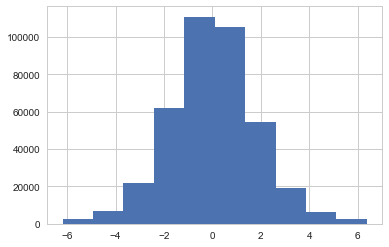

In [450]:
dxy = train.loc[:, xy_cols].values - train.loc[:, exy_cols].values
normed_dxy = dxy / np.sqrt(train.loc[:, edxy_cols].values)
pd_ndxy = pd.DataFrame(normed_dxy)

alpha = .02
qal = pd_ndxy[0].quantile(alpha/2)
qar = pd_ndxy[0].quantile(1-alpha/2)
cut_pd_ndxy = pd_ndxy.loc[(pd_ndxy[0] > qal) & (pd_ndxy[0] < qar) , 0]

plt.hist(cut_pd_ndxy[:])
# normed_dxy[:, 0].shape
# pd.DataFrame(normed_dxy).describe()

In [451]:
sts.shapiro(cut_pd_ndxy.values[:1000])

(0.9935914874076843, 0.0002713268913794309)

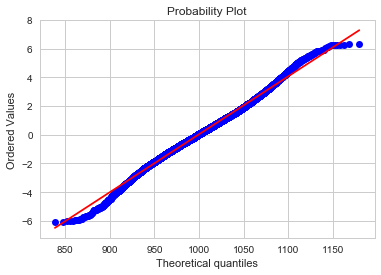

In [472]:
_ = sts.probplot(cut_pd_ndxy[:10000], dist=sts.chi2(1000), plot=plt)

In [70]:
train.loc[train[x_cols[3]].isna(), hit_type_cols].sample(5)

,MatchedHit_TYPE[0],MatchedHit_TYPE[1],MatchedHit_TYPE[2],MatchedHit_TYPE[3]
id,,,,
163768.0,1,1,1,0
27333.0,2,2,2,0
190311.0,2,2,2,0
2819322.0,2,2,2,0
178044.0,1,2,1,0


In [242]:
train.loc[train.label == 0, z_cols].describe()

,MatchedHit_Z[0],MatchedHit_Z[1],MatchedHit_Z[2],MatchedHit_Z[3]
count,30588.000000,30588.000000,28150.000000,29016.00000
mean,15267.529090,16475.297451,17668.125277,18875.68396
std,107.841824,107.580262,107.957386,107.69669
min,15105.030000,16308.190000,17499.955000,18707.02300
25%,15199.486000,16403.846000,17596.334000,18804.25200
50%,15315.786000,16521.568000,17714.242000,18922.01400
75%,15398.049000,16603.707000,17796.380000,19002.25400
max,15418.304000,16626.639000,17821.273000,19031.20700


In [241]:
train.loc[train.label == 1, z_cols].describe()

,MatchedHit_Z[0],MatchedHit_Z[1],MatchedHit_Z[2],MatchedHit_Z[3]
count,369412.000000,369412.000000,365261.000000,363901.000000
mean,15261.031272,16466.674363,17659.706595,18867.787674
std,108.533044,108.753570,108.789209,108.580489
min,15105.030000,16308.190000,17499.955000,18707.023000
25%,15188.960000,16340.415000,17534.979000,18744.842000
50%,15251.503000,16424.484000,17616.951000,18826.674000
75%,15332.328000,16538.629000,17732.977000,18940.537000
max,15418.309000,16626.645000,17821.280000,19031.213000


In [353]:
pd_dxy = pd.DataFrame(np.abs(normed_dxy))

In [305]:
pd_dxy.describe()

,0,1,2,3,4,5,6,7
count,400000.000000,400000.000000,393411.000000,392917.000000,400000.000000,400000.000000,393411.000000,392917.000000
mean,24.454156,34.641797,55.115376,82.235222,44.436536,56.323167,60.666571,90.283579
std,71.512594,86.253810,83.035893,196.519255,80.477527,117.492617,103.891543,237.230767
min,0.000000,0.000000,0.000000,0.000070,0.000150,0.000300,0.000200,0.000000
25%,4.693533,6.565212,13.498400,16.140126,11.369493,13.105000,14.882585,17.423350
50%,11.396850,16.292300,32.032200,39.148220,26.196520,30.627200,35.011040,41.748560
75%,25.194050,36.961782,68.569250,86.255340,54.350025,64.470225,74.232430,90.927300
max,6320.960800,5649.827700,6307.441000,10918.146000,2127.393000,4416.420200,7025.129200,8777.228000


In [354]:
pd_dxy.describe()

,0,1,2,3,4,5,6,7
count,400000.000000,400000.000000,393411.000000,392917.000000,400000.000000,400000.000000,393411.000000,392917.000000
mean,1.713980,1.372812,1.701793,1.552088,3.794636,2.601372,1.905576,1.706330
std,3.550669,2.503900,1.804259,1.754050,5.389700,3.612453,2.127742,2.081799
min,0.000000,0.000000,0.000000,0.000002,0.000028,0.000008,0.000004,0.000000
25%,0.531615,0.454593,0.587041,0.534488,1.138821,0.802064,0.638485,0.564721
50%,1.140288,0.971498,1.266216,1.144472,2.507850,1.751996,1.382168,1.219023
75%,2.025947,1.704135,2.266499,2.037882,4.665499,3.217747,2.497143,2.197711
max,417.382389,291.978705,120.457442,129.113715,731.475094,347.029573,126.325940,239.068608


In [380]:
# least = pd_dxy.sort_values(by=[0])[:20].index
greatest = pd_dxy.sort_values(by=[3], ascending=False)[:1000].index
strange_ind = greatest #least.append(greatest)

In [374]:
pd_dxy.quantile(.995)

0    20.491097
1    13.467475
2     9.868190
3     9.962956
4    31.532359
5    22.678627
6    12.055387
7    11.774025
Name: 0.995, dtype: float64

In [378]:
train.loc[(pd_dxy.quantile(.9999) < pd_dxy).loc[:, 3], 'label'].describe()

count    40.00000
mean      0.50000
std       0.50637
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000
Name: label, dtype: float64

In [381]:
train.loc[strange_ind[:20], foi_stats_cols + x_cols + dx_cols + ex_cols + edx_cols + train_cols[:1]]

,FOI_hits_N,NShared,MatchedHit_X[0],MatchedHit_X[1],MatchedHit_X[2],MatchedHit_X[3],MatchedHit_DX[0],MatchedHit_DX[1],MatchedHit_DX[2],MatchedHit_DX[3],Lextra_X[0],Lextra_X[1],Lextra_X[2],Lextra_X[3],Mextra_DX2[0],Mextra_DX2[1],Mextra_DX2[2],Mextra_DX2[3],label
266185,14,1,255.80000,251.25166,318.40000,246.32000,19.250000,3.458333,14.833333,15.833333,252.01962,272.06067,292.10175,312.14280,0.021972,0.062955,0.138056,0.259901,1
389843,6,0,-1862.88000,-2009.70000,-2228.97000,5303.12000,25.500000,27.500000,118.000000,756.000000,-1870.52760,-2117.37450,-2364.22120,-2611.06800,12.670314,185.446350,1454.585700,4995.777000,1
223198,9,0,-2537.68000,-2735.90000,-2714.87000,-767.57000,25.500000,27.500000,118.000000,756.000000,-2544.89920,-2759.98440,-2975.06930,-3190.15450,42.124170,119.223780,261.442700,497.756000,0
357437,11,0,267.80000,288.76000,178.00000,763.32000,12.750000,13.750000,59.000000,756.000000,287.50525,307.22980,326.95430,346.67886,1.465599,4.283019,9.400211,17.592232,0
266268,5,0,1238.10000,1309.06000,1450.60000,1866.82000,12.750000,13.750000,59.000000,378.000000,1233.16490,1326.43440,1419.70410,1512.97360,2.409279,6.816480,14.918847,28.141195,1
125064,44,0,-516.92170,-558.59170,-609.33670,-746.73670,3.208333,3.458333,14.833333,15.833333,-516.41120,-558.15820,-599.90515,-641.65216,0.207971,0.602885,1.330138,2.511735,0
333346,10,0,2207.10000,2360.56000,2512.60000,2845.82000,12.750000,13.750000,59.000000,63.000000,2174.70310,2346.43140,2518.15970,2689.88820,0.603082,1.686119,3.694858,6.993017,0
30292,6,0,-736.33000,-794.65000,-895.17000,-1145.57000,12.750000,13.750000,59.000000,378.000000,-746.68964,-802.72290,-858.75620,-914.78955,1.304668,3.687668,8.098000,15.336807,1
256609,4,0,-1004.08000,-1028.40000,-1072.17000,-767.57000,25.500000,27.500000,118.000000,756.000000,-972.29193,-1043.61650,-1114.94090,-1186.26540,5.013962,14.182890,30.952969,58.229534,1
155314,26,0,-315.08835,-340.75833,-375.50333,-433.47000,3.208333,3.458333,14.833333,15.833333,-312.40604,-336.47202,-360.53802,-384.60400,0.069369,0.200059,0.438728,0.823923,0


In [310]:
train.loc[strange_ind, foi_stats_cols + y_cols + dy_cols + ey_cols + edy_cols + train_cols[:1]]

,FOI_hits_N,NShared,MatchedHit_Y[0],MatchedHit_Y[1],MatchedHit_Y[2],MatchedHit_Y[3],MatchedHit_DY[0],MatchedHit_DY[1],MatchedHit_DY[2],MatchedHit_DY[3],Lextra_Y[0],Lextra_Y[1],Lextra_Y[2],Lextra_Y[3],Mextra_DY2[0],Mextra_DY2[1],Mextra_DY2[2],Mextra_DY2[3],label
62486,2,0,-3423.12450,-3376.584200,NaN,NaN,126.278550,136.278490,NaN,NaN,-3011.30790,-3239.329600,-3467.35100,-3695.37280,2459.56100,7423.38570,18078.4650,37895.3100,0
157369,3,0,1138.84580,-411.307280,1244.205100,NaN,126.278550,136.278490,73.078896,NaN,1107.99760,1194.928000,1281.85830,1368.78870,644.56840,1849.88380,4151.4307,8055.4730,1
162765,8,0,-888.64105,-465.681400,-499.195250,-491.225770,126.278550,16.929256,18.179249,19.429240,-602.77450,-649.678160,-696.58185,-743.48560,729.56430,2091.46340,4654.1714,9116.4570,1
380650,5,0,-1975.25330,-2852.412000,-3060.674800,-2974.406000,63.078957,136.278490,146.278410,156.278350,-2123.19000,-2286.864000,-2450.53830,-2614.21240,1455.27930,4340.49170,10286.9900,21089.9600,1
393769,4,0,-1402.45700,-137.105240,-1239.277600,-3123.908000,126.278550,136.278490,73.078896,633.725900,-1437.72470,-1549.574300,-1661.42410,-1773.27370,519.31400,1527.04430,3504.8079,6911.7440,0
239639,3,0,-445.04390,-312.232400,NaN,-2349.463600,63.078957,33.979145,NaN,156.278350,-735.83795,-791.607670,-847.37744,-903.14720,2327.50930,7019.88900,15962.1780,31007.5140,1
191754,5,0,2153.12230,1952.959200,NaN,1779.267100,126.278550,68.078926,NaN,78.078860,1865.56520,2010.742100,2155.91900,2301.09570,837.01020,2487.38300,5658.4346,11015.7040,0
93121,2,0,1884.72550,680.363650,NaN,NaN,126.278550,136.278490,NaN,NaN,1514.18770,1630.422600,1746.65730,1862.89220,2046.84130,6069.45700,14313.3100,29183.0680,1
368216,8,0,-190.15862,-36.227894,108.200806,-39.421116,63.078957,33.979145,36.479130,38.979115,82.27263,88.410164,94.54769,100.68523,972.49585,2810.86870,6280.0107,12100.1230,0
315108,3,0,-1196.55460,-963.828200,NaN,-1729.816400,63.078957,136.278490,NaN,156.278350,-1000.31650,-1078.425800,-1156.53520,-1234.64440,914.43567,2675.52930,6061.3706,12057.3390,0


## < 6k

In [75]:
train.loc[(train.P < 6000.), ['label']].describe()

,label
count,21690.000000
mean,0.893177
std,0.308896
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [155]:
train.loc[(train.P < 6000.) & (train[hit_type_cols[0]] > 1) & (train[hit_type_cols[1]] > 1), ['label']].describe()

,label
count,18104.000000
mean,0.949901
std,0.218156
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


## 6k < .. < 10k

In [76]:
train.loc[(train.P > 6000.) & (train.P < 10000.), ['label']].describe()

,label
count,57739.000000
mean,0.894006
std,0.307833
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [156]:
train.loc[(train.P > 6000.) & (train.P < 10000.) & (train[hit_type_cols[0]] > 1) & (train[hit_type_cols[1]] > 1) & ((train[hit_type_cols[2]] > 1) | (train[hit_type_cols[3]] > 1)), ['label']].describe()

,label
count,49856.000000
mean,0.951320
std,0.215201
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


## > 10k

In [81]:
train.loc[train.P > 10000., ['label']].describe()

,label
count,320571.000000
mean,0.930901
std,0.253622
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [104]:
train.loc[(train.P > 10000.) & (train[hit_type_cols[2]] > 1) & (train[hit_type_cols[3]] > 1), ['label']].describe()

,label
count,255677.000000
mean,0.953386
std,0.210810
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000
